# Seq2Seq Machine Translation with Attention

## 1. Data exploration and preprocessing

In [13]:
# Get datasets as lists
with open("./data/europarl-v7.de-en.de") as file:
    ger = [line.rstrip() for line in file]
with open("./data/europarl-v7.de-en.en") as file:
    eng = [line.rstrip() for line in file]

In [17]:
print(len(eng))

1920209


In [18]:
len(ger)

1920209

In [19]:
words = 0
for sent in eng:
    words += len(sent.split())
print(f"Number of english words: {words}")

words = 0
for sent in ger:
    words += len(sent.split())
print(f"Number of german words: {words}")

Number of english words: 47882343
Number of german words: 44614285


In [2]:
# Tokenization - use spacy
import spacy
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ger(text):
    """
    Take german sentence and tokenize it using spacy. 
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_eng(text):
    """
    Take english sentence and tokenize it using spacy. 
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [225]:
from torchtext.data import Field, BucketIterator

src_field = Field(init_token = '<sos>', 
            eos_token = '<eos>',
            pad_token='<pad>', 
            unk_token='<unk>',
            lower = True, 
            include_lengths = True,
            sequential=True,
            batch_first=True)

trg_field = Field(init_token = '<sos>', 
            eos_token = '<eos>',
            pad_token='<pad>', 
            unk_token='<unk>',
            lower = True, 
            include_lengths = True,
            sequential=True,batch_first=True)

In [165]:
# Tokenize data
ger_token = [tokenize_ger(sent) for sent in ger]
eng_token = [tokenize_eng(sent) for sent in eng]

In [166]:
# Vocab size 32K
# https://jlibovicky.github.io/2021/07/24/MT-Weekly-The-Wisdom-of-the-WMT-Crowd.html

In [167]:
max_vocab_size = 32000
src_field.build_vocab(ger_token, min_freq=2, max_size=max_vocab_size)
trg_field.build_vocab(eng_token,  min_freq=2, max_size=max_vocab_size)

In [163]:
# Frequency hodls all frequencies
print(len(SRC.vocab.freqs))

# ITOS/
print(len(SRC.vocab.stoi))
print(len(SRC.vocab.itos))

397884
32004
32004


In [168]:
from torch.utils.data import Dataset
class TextDtaatset(Dataset):

  def __init__(self, data):
    self.text = data
    


  def __len__(self):

    return len(self.text)


  def __getitem__(self, idx):

    return self.text[idx]

In [169]:
ger_dataset = TextDtaatset(data=ger_token)

In [177]:
# Define iterator
from torchtext.data import BucketIterator

iterator = BucketIterator.splits(datasets=ger_dataset, batch_size=2, sort_key=lambda x: len(x))

In [195]:
from torchtext.data import TabularDataset

with open('./data/train_de') as src, open('./data/train_en') as tgt:
    with open('./data/train.csv','w') as file:
        for src_sentence, tgt_sentence in zip(src, tgt):
            line = f'{src_sentence.rstrip()} , {tgt_sentence.rstrip()}'
            file.write(line)
            file.write('\n')

with open('./data/val_de') as src, open('./data/val_en') as tgt:
    with open('./data/val.csv','w') as file:
        for src_sentence, tgt_sentence in zip(src, tgt):
            line = f'{src_sentence.rstrip()} , {tgt_sentence.rstrip()}'
            file.write(line)
            file.write('\n')

In [226]:
(train_obj, valid_obj) = TabularDataset.splits(
  path="",
  train='./data/val.csv',
  validation='./data/val.csv',
  format='csv',
  fields=[('src',src_field ), ('trg', trg_field)])

In [249]:
from seq2seq_attention.build_dataloaders import build_vocab
build_vocab(train_set=train_obj)

NameError: name 'src_field' is not defined

: 

In [247]:
src_field.build_vocab(train_obj, min_freq=1, max_size=max_vocab_size)
trg_field.build_vocab(train_obj,  min_freq=1, max_size=max_vocab_size)

AttributeError: 'NoneType' object has no attribute 'build_vocab'

In [240]:
train_iter = BucketIterator(
  dataset=train_obj,
  batch_size = 2,
  sort_key=lambda x: len(x.src),
  shuffle=True,
  device="cpu",)

In [241]:
example=next(iter(train_iter))
src = example.src
trg = example.trg
print(src)
print(trg)

(tensor([[ 2,  4,  6,  3,  1,  1],
        [ 2, 14,  8,  7, 10,  3]]), tensor([4, 6]))
(tensor([[ 2,  5,  9,  3,  1],
        [ 2,  7,  4, 10,  3]]), tensor([4, 5]))


In [242]:
# itos is list of token strings with their idx 
for i in src[0][0]:
    print(src_field.vocab.itos[i])
print()
for i in trg[0][0]:
    print(trg_field.vocab.itos[i])

# The second element in the tuple is the real length that we pass to the packed_seq!

<sos>
bestens
danke
<eos>
<pad>
<pad>

<sos>
fine
thanks
<eos>
<pad>


In [205]:
trg

In [12]:
# Bidirectional GRU
import torch.nn as nn
emb = nn.Embedding(num_embeddings=5, embedding_dim=10)
gru = nn.GRU(input_size=10, hidden_size=4, num_layers=1,  bidirectional = True, batch_first=True, bias=True,)
        

In [48]:
import torch
input = torch.tensor([[1,2], [1,2], [0,1]])
input_len = torch.tensor([2,2,1])
embed = emb(input)
packed_embedded_src = nn.utils.rnn.pack_padded_sequence(
                embed, lengths=input_len, batch_first=True, enforce_sorted=True
            )
all, last = gru(packed_embedded_src)

In [49]:
# Concatenaeted version of the hdiden states 
# data: (num_real_seq, 2*hidden_dim)
all.data.shape

torch.Size([5, 8])

In [50]:
# (Bidir, batch, hidden_dim) two hidden states for all directions, 
last.shape

torch.Size([2, 3, 4])

In [52]:
# transform all back 
out, _ =nn.utils.rnn.pad_packed_sequence(
                all,batch_first=True, 
            )

In [53]:
out.shape

torch.Size([3, 2, 8])

In [172]:
hiden_final = torch.cat([last[0,:,:], last[1,:,:]], dim=1)
hiden_final.shape


torch.Size([3, 8])

In [65]:
# Now lets concat each one with the resbectve 
hidden.unsqueeze(1).repeat(1, src_len, 1)

torch.Size([3, 2, 8])

In [81]:
torch.cat([out, hiden_final.unsqueeze(1).repeat(1,2,1)], dim=2).shape

torch.Size([3, 2, 16])

In [78]:
hiden_final.unsqueeze(1).repeat(1,6,1).shape

torch.Size([3, 6, 8])

In [94]:
true_len = torch.tensor([1,2,3,4])
src_len_padded=6

mask = torch.zeros((4,src_len_padded), dtype=torch.bool)
mask[[1,2,3,3,3,3],[1]]

tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])

In [101]:
a = torch.tensor([[1,2,3], [1,1,2]])

a[torch.tensor([[1,2,3], [1,1,2]])==1] = 10
a

tensor([[10,  2,  3],
        [10, 10,  2]])

In [113]:
a = torch.tensor([[1,2,3], [1,1,2]])
b = torch.tensor([[1,3], [1,2]])
torch.cat([a,b], dim=1).unsqueeze(1).shape

torch.Size([2, 1, 5])

In [177]:
a = torch.tensor([[1,2,3], [1,1,2]])
b = torch.tensor([[1], [1]])
print(a.shape)
print(b.shape)
torch.cat([a,b], dim=1).shape

torch.Size([2, 3])
torch.Size([2, 1])


torch.Size([2, 4])

In [117]:
torch.full(size=(2,1), fill_value=1)

tensor([[1],
        [1]])

In [171]:
loss = torch.nn.CrossEntropyLoss()
y = torch.tensor([[1,1,1], [1,1,1]], dtype=torch.long)
out = torch.tensor([[[0,10,-1, -4], [0,10,-1,-4], [0,10,-1,-4]], [[0,10,-1,-4],[0,10,-1,-4],[0,10,-1,-4]]],dtype=torch.float32)
out=out.permute(0,2,1)
print(y.shape)
print(out.shape)
loss(out, y)

# Works!

torch.Size([2, 3])
torch.Size([2, 4, 3])


tensor(6.2931e-05)

In [141]:
loss = torch.nn.CrossEntropyLoss()
y = torch.tensor([[1,1,1], [1,1,1]], dtype=torch.long)
out = torch.tensor([[[100,10,-1, -4], [0,10,-1,-4], [0,10,-1,-4]], [[0,10,-1,-4],[0,10,-1,-4],[0,10,-1,-4]]],dtype=torch.float32)
out=out.permute(0,2,1)
loss(out, y)

tensor(15.0001)

In [142]:
loss = torch.nn.CrossEntropyLoss()
y = torch.tensor([[1,1,1], [1,1,1]], dtype=torch.long)
out = torch.tensor([[[100,10,-1, -4], [100,10,-1,-4], [0,10,-1,-4]], [[0,10,-1,-4],[0,10,-1,-4],[0,10,-1,-4]]],dtype=torch.float32)
out=out.permute(0,2,1)
loss(out, y)

 # Gets summed!

tensor(30.0000)

In [162]:
# Weighted hidden states
all_hidden = torch.tensor([[[1,2,0], [3,4,0]], 
                           [[1,2,0], [3,4,0]], 
                           [[1,2,0], [3,4,0]], 
                           [[1,2,0], [3,4,0]]])
weights = torch.tensor([[0,1], [1,0], [0,0], [1,1]])

def weighted_sum(H, K):
    weighted = (H * K.unsqueeze(2)).sum(dim=1)
    return weighted

In [169]:
print(all_hidden.shape)
print(weights.shape)

torch.Size([4, 2, 3])
torch.Size([4, 2])


In [168]:
weighted_sum(all_hidden, weights).shape

torch.Size([4, 3])

In [166]:
weighted_sum(all_hidden, weights)

tensor([[3, 4, 0],
        [1, 2, 0],
        [0, 0, 0],
        [4, 6, 0]])

In [ ]:
emb(torch.tensor([]))

In [3]:
exp_name = "experiment_4"

lr = 1e-4
batch_size = 128
epochs = 15
max_vocab_size = 8000
min_freq = 2
enc_emb_dim = 256
hidden_dim_enc = 512
hidden_dim_dec = 512
num_layers_enc = 1
num_layers_dec = 1
emb_dim_trg = 256
device = "cpu"
teacher_forcing = 0.8
dropout=0

from seq2seq_attention.build_dataloaders import build_fields, get_datasets, build_vocab

src, trg = build_fields()
src_field, trg_field = build_fields()
train_set, val_set, test_set = get_datasets(train_path="./data/processed/train.csv", 
                                            val_path="./data/processed/train_mini.csv", 
                                            test_path="./data/processed/train_mini.csv", 
                                            src_field=src_field, 
                                            trg_field=trg_field)
build_vocab(src_field=src_field, trg_field=trg_field, train_set=train_set, min_freq=min_freq, max_vocab_size=max_vocab_size)

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from seq2seq_attention.model import Seq2Seq_Architecture_with_Att, Seq2Seq_With_Attention, Encoder, Decoder, Attention
import torch 

# Init from file
best_model_vals = torch.load("./experiments/Experiment_11_safe/best_model.pt")

model = Seq2Seq_With_Attention(
        lr=lr,
        enc_vocab_size=len(src_field.vocab),
        vocab_size_trg=len(trg_field.vocab),
        enc_emb_dim=enc_emb_dim,
        hidden_dim_enc=hidden_dim_enc,
        hidden_dim_dec=hidden_dim_dec,
        padding_idx=src_field.vocab.stoi["<pad>"],
        num_layers_enc=num_layers_enc,
        num_layers_dec=num_layers_dec,
        emb_dim_trg=emb_dim_trg,
        trg_pad_idx=trg_field.vocab.stoi["<pad>"],
        device=device,
        seq_beginning_token_idx=trg_field.vocab.stoi[trg_field.init_token],
        dropout=dropout,
    )


model.seq2seq.load_state_dict(best_model_vals["model_state_dict"])

<All keys matched successfully>

In [23]:
from seq2seq_attention.visualize_attention import get_attention_frames
examples = ["Dennoch ist das ein wichtiges Kriterium für die Europäische Union.",
            "Das dürfen wir auf keinen Fall vergessen.",
            "Leider war das nicht der Fall."]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
trans

['however , this is an important criterion for the european union .',
 'we must not forget that any case .',
 'unfortunately , that was not the case .']

In [ ]:
"Das kann nicht sein!"

torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])


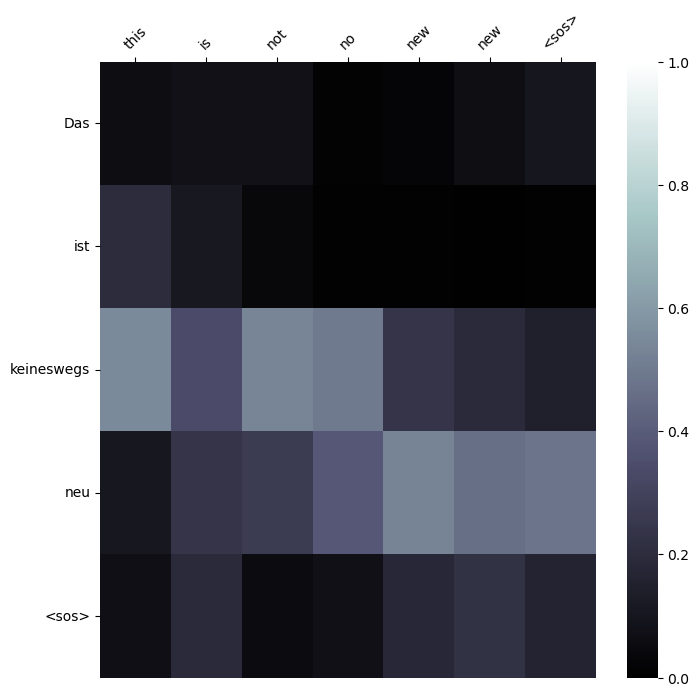

In [33]:

from seq2seq_attention.visualize_attention import plot_attention
import matplotlib.pyplot as plt
from seq2seq_attention.visualize_attention import get_attention_frames
sent = "Das ist keineswegs neu"
examples = [sent]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
frame = frames[0]
plt.figure(figsize=(8,8))
plot = plot_attention(frame)
